# **LIBRARIES**

In [2]:
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# **CLEANING AND SCALING**

In [4]:
def load_and_clean_data(file_path):
    with open(file_path, 'r') as file:
        data_text = file.read()

    lines = data_text.splitlines()

    labels = []
    features = []

    pattern = re.compile(r"([+-]1)\s+(.+)")

    for line in lines:
        match = pattern.match(line)
        if match:
            label = int(match.group(1))
            feature_values = match.group(2).strip().split() 
            
            feature_values = [float(f.split(":")[1]) for f in feature_values] # Converts feature values from 'index:value' to just 'value'

            labels.append(label)
            features.append(feature_values)

    df = pd.DataFrame(features)

    # Add the label column as the first column
    df.insert(0, 'Outcome', labels)
    df.columns = ['Outcome'] + [f'{i}' for i in range(1, len(df.columns))]
    
    
    # Scale the features
    X = df.iloc[:, 1:].values  # All columns except the first (features)
    y = df.iloc[:, 0].values   # First column (labels)
    y = np.where(y == -1, -1, 1) # Formats labels to -1 and 1
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(X_scaled, columns=[f'{i}' for i in range(1, X_scaled.shape[1] + 1)])
    df_scaled.insert(0, 'Outcome', y)

    return df_scaled

file_path = 'data.txt'  
df = load_and_clean_data(file_path)

print(df.head())

df.to_csv('input_scaled.csv', index=False)


   Outcome         1         2         3         4         5         6  \
0       -1  0.639947  0.848324  0.149641  0.907270 -0.692891  0.204013   
1        1 -0.844885 -1.123396 -0.160546  0.530902 -0.692891 -0.684422   
2       -1  1.233880  1.943724 -0.263941 -1.288212 -0.692891 -1.103256   
3        1 -0.844885 -0.998208 -0.160546  0.154533  0.123302 -0.494043   
4       -1 -1.141852  0.504055 -1.504687  0.907270  0.765836  1.409745   

          7         8  
0  0.468492  1.425995  
1 -0.365061 -0.190672  
2  0.604397 -0.105584  
3 -0.920763 -1.041549  
4  5.484909 -0.020496  


# **PERCEPTRON**

In [20]:
class Perceptron:
    def __init__(self, learning_rate=0.001, max_iterations=1000):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.weights = None
        self.bias = 0
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        
        for _ in range(self.max_iterations):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_pred = np.sign(linear_output)
                if y_pred != y[idx]:
                    update = self.learning_rate * y[idx]
                    self.weights += update * x_i
                    self.bias += update
    
    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_pred = np.sign(linear_output)
        return y_pred
        
# Print results in a table
def print_results_table(results):
    df_results = pd.DataFrame(results, columns=["Learning Rate", "Accuracy", "Precision", "Recall", "F1 Score"])
    print(df_results.to_string(index=False))


# Load dataset from csv file
data = pd.read_csv('input_scaled.csv')

X = data.iloc[:, 1:].values  # Features (all columns except the first)
y = data.iloc[:, 0].values   # Labels (first column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# GRID SEARCH FOR LEARNING RATES
learning_rates = [0.001, 0.01, 0.1]
best_accuracy = 0
best_learning_rate = None
results = []

for lr in learning_rates:
    print(f"Training Perceptron with learning rate: {lr}")
    
    # Initialize and train the Perceptron with the current learning rate
    perceptron = Perceptron(learning_rate=lr, max_iterations=1000)
    perceptron.fit(X_train, y_train)

    # Predict on the test set
    y_pred = perceptron.predict(X_test)

    #Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # print(f"Accuracy: {accuracy * 100:.2f}%")
    # print(f"Precision: {precision * 100:.2f}%")
    # print(f"Recall: {recall * 100:.2f}%")
    # print(f"F1 Score: {f1 * 100:.2f}%")

    results.append([lr, round(accuracy * 100, 2), round(precision * 100, 2), round(recall * 100, 2), round(f1 * 100, 2)])

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_learning_rate = lr
        
# results in a table
print("\nGrid Search Results:")
print_results_table(results)

print(f"\nBest learning rate: {best_learning_rate} with accuracy: {best_accuracy * 100:.2f}%")

Training Perceptron with learning rate: 0.001
Training Perceptron with learning rate: 0.01
Training Perceptron with learning rate: 0.1

Grid Search Results:
 Learning Rate  Accuracy  Precision  Recall  F1 Score
         0.001     79.22      80.47   90.07      85.0
         0.010     79.22      80.47   90.07      85.0
         0.100     79.22      80.47   90.07      85.0

Best learning rate: 0.001 with accuracy: 79.22%


# **VISUALIZATIONS**

# Feature Correlation Heatmap

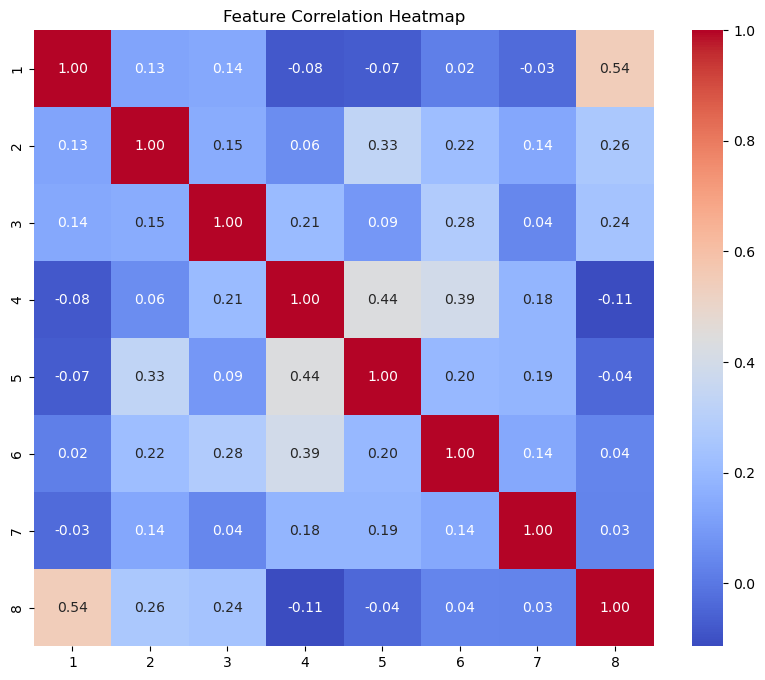

In [24]:
corr_matrix = df.drop('Outcome', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# CONFUSION MATRIX

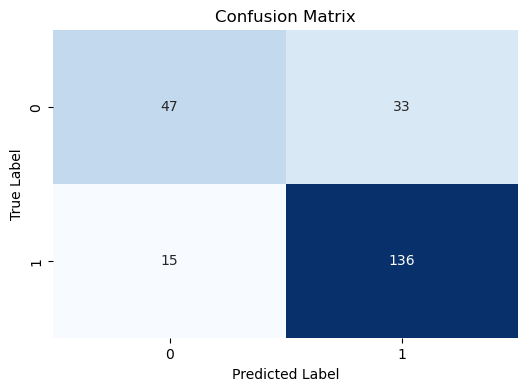

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Outcome variable distribution

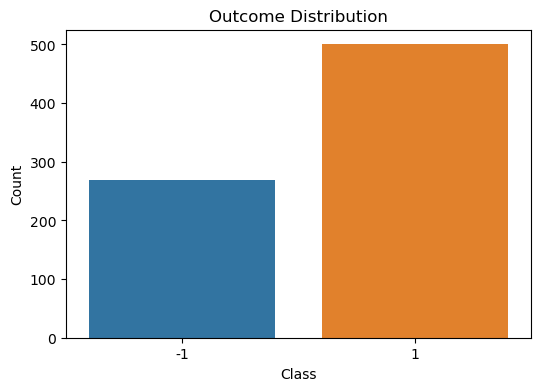

Exact Outcome Distribution:
 1    500
-1    268
Name: Outcome, dtype: int64


In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Outcome Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

outcome_count = df['Outcome'].value_counts()
print("Exact Outcome Distribution:")
print(outcome_count)

# Feature boxplots

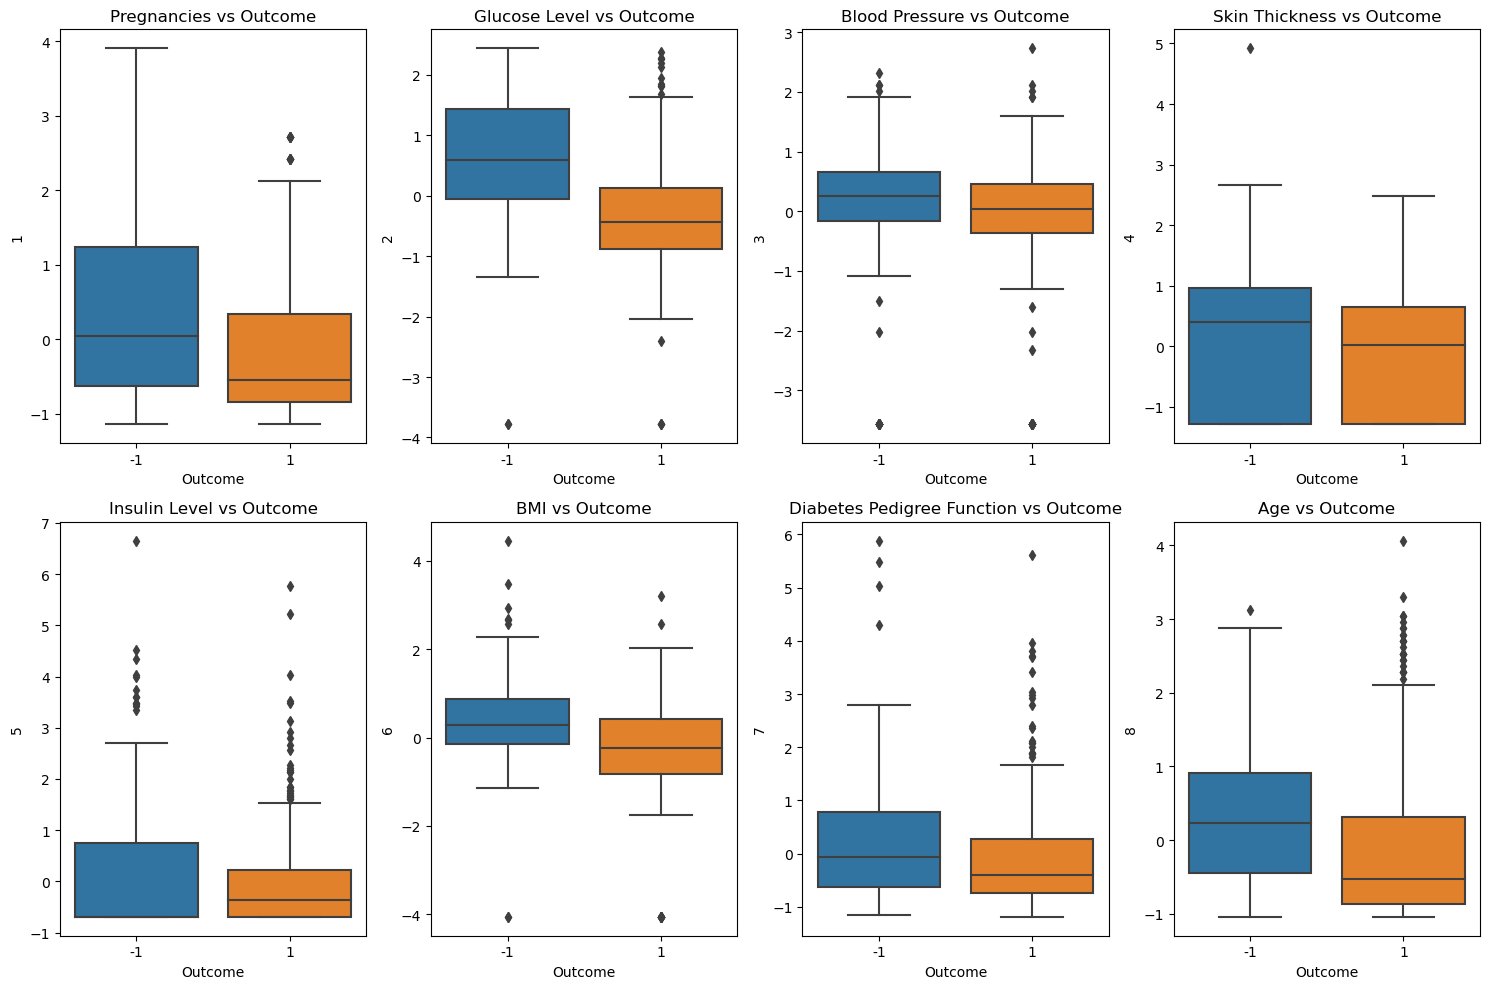

In [33]:
feature_labels = [
    'Pregnancies',
    'Glucose Level',
    'Blood Pressure',
    'Skin Thickness',
    'Insulin Level',
    'BMI',
    'Diabetes Pedigree Function',
    'Age'
]

plt.figure(figsize=(15, 10))

for i, column in enumerate(df.columns[1:], 1):  # Skip the 'Outcome' column
    plt.subplot(2, 4, i)  # Adjust rows and columns based on the number of features
    sns.boxplot(x='Outcome', y=column, data=df)
    plt.title(f'{feature_labels[i-1]} vs Outcome')  # Use the custom label

plt.tight_layout()
plt.show()